# Backpropagation Part 1

The objective of this notebook is to perform backpropagation and overfit a model to training data without the help of TensorFlow or PyTorch autograd. I will derive the gradients of 

- Affine transformation, a.k.a. Dense layer in TensorFlow Keras
- ReLU Activation
- Sigmoid Activation
- Mean Squared Error

## Demonstrate with TensorFlow

Let's start with a toy example of learning a sine function using TensorFlow. I will use root mean squared loss. Since my model uses sigmoid activation, the outputs can only be in `[0, 1]` range. I need to transform the sine function from `[-1, 1]` to `[0, 1]` range.

$$
\frac{\sin(x) + 1}{2} \approx \text{model}(x) = \hat{y} \in [0, 1]
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2023-05-26 22:33:40.670056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 22:33:40.785539: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 22:33:41.325666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 22:33:41.325718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               256       
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________
X: (512, 1)
Y: (512, 1)


2023-05-26 22:33:42.097793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 22:33:42.103342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-26 22:33:42.103362: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-26 22:33:42.103963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

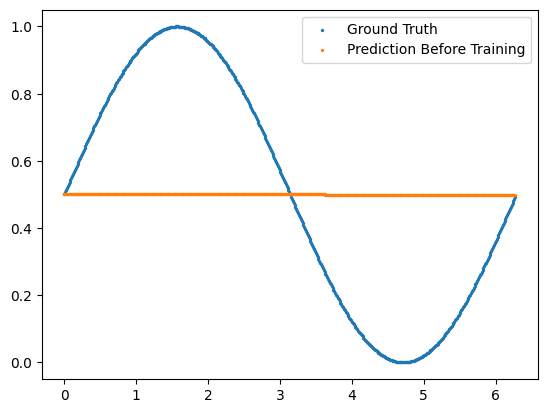

In [2]:
tf.random.set_seed(1337)
tf_model = Sequential([
    Dense(128, activation="relu", name="dense_1", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(128, activation="relu", name="dense_2", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(1, activation="sigmoid", name="dense_3", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
])
tf_model.build((None, 1))
tf_model.summary()

x = np.arange(0., 2*np.pi, 2*np.pi/512)
np.random.shuffle(x)
y_true = (np.sin(x) + 1) / 2

x = np.expand_dims(x, axis=-1)
y_true = np.expand_dims(y_true, axis=-1)
y_pred = tf_model(x).numpy()

print(f"X: {x.shape}")
print(f"Y: {y_true.shape}")
plt.scatter(x.flatten(), y_true.flatten(), s=2, label="Ground Truth")
plt.scatter(x.flatten(), y_pred.flatten(), s=2, label="Prediction Before Training")
plt.legend()

Compute gradients and perform training.

Training progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]

X: (512, 1)
Y: (512, 1)


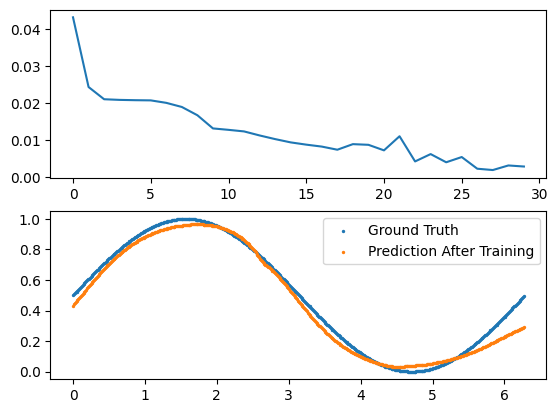

In [3]:
N = x.shape[0]
batch_size = 16
epochs = 30
history = []
optimizer = Adam(learning_rate=1e-2)
mse = MeanSquaredError()

for epoch in tqdm(range(epochs), desc="Training progress"):
    for i in range(N // batch_size):
        start = i * batch_size
        end = start + batch_size
        batch_x = x[start:end]
        batch_y = y_true[start:end]
        
        with tf.GradientTape() as tape:
            batch_y_pred = tf_model(batch_x)
            loss = mse(batch_y, batch_y_pred)
            
        gradients = tape.gradient(loss, tf_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, tf_model.trainable_variables))
    
    # Compute epoch loss
    y_pred = tf_model(x)
    loss = mse(y_true, y_pred)
    history.append((epoch, loss.numpy()))


fig, axs = plt.subplots(2)
axs[0].plot([dp[0] for dp in history], [dp[1] for dp in history])
y_pred = tf_model(x).numpy()

print(f"X: {x.shape}")
print(f"Y: {y_true.shape}")
axs[1].scatter(x.flatten(), y_true.flatten(), s=2, label="Ground Truth")
axs[1].scatter(x.flatten(), y_pred.flatten(), s=2, label="Prediction After Training")
axs[1].legend()

## Demonstrate with Numpy

Without the help of auto differentiation, I will write the same functionality with numpy and some calculus. I will use random normal weight initialization. Keep in mind that `numpy` returns random normal distribution with `mean=0` and `std=1`. A new random normal distribution can be defined as follows.

$$
X^\prime = \sigma X + \mu
$$

In [4]:
from IPython.display import Code

from layers.dense import Dense
from layers.relu import ReLU
from layers.sigmoid import Sigmoid
from losses.mse import MeanSquaredError


class NumpyModel:
    def __init__(self, weight_stddev=0.01):
        self.params = {
            "dense_1/kernel": weight_stddev * np.random.randn(1, 128),
            "dense_1/bias": np.zeros((128,)),
            "dense_2/kernel": weight_stddev * np.random.randn(128, 128),
            "dense_2/bias": np.zeros((128,)),
            "dense_3/kernel": weight_stddev * np.random.randn(128, 1),
            "dense_3/bias": np.zeros((1,)),
        }
        self.dense_1 = Dense()
        self.act_1 = ReLU()
        self.dense_2 = Dense()
        self.act_2 = ReLU()
        self.dense_3 = Dense()
        self.act_3 = Sigmoid()
        
    def __call__(self, x):
        x = self.dense_1(x, self.params['dense_1/kernel'], self.params['dense_1/bias'])
        x = self.act_1(x)
        x = self.dense_2(x, self.params['dense_2/kernel'], self.params['dense_2/bias'])
        x = self.act_2(x)
        x = self.dense_3(x, self.params['dense_3/kernel'], self.params['dense_3/bias'])
        x = self.act_3(x)
        return x

Now I have a model that produces the output and loss value like the TensorFlow model I setup above.

In [5]:
np_model = NumpyModel()
loss_fn = MeanSquaredError()
y_pred = np_model(x)
loss = loss_fn(y_true, y_pred)
print("Loss:\n", loss.flatten())

Loss:
 [0.12498234]


## Verify Gradient Computation

### Gradient of Loss

The L2 loss is defined as follows.

$$
L = \frac{1}{N}\Sigma_{i=0}^{N-1} (y_{i} - \hat{y}_{i})^2
$$

The derivative of loss with respect to prediction is then:

$$
\frac{\partial L}{\partial \hat{y}} = \frac{2}{N} \cdot (y - \hat{y})
$$

In [6]:
Code(filename='losses/mse.py', language='python')

import numpy as np


class MeanSquaredError:
    def __init__(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        return np.sum((y_true - y_pred)**2) / np.prod(y_pred.shape)

    def gradients(self):
        if self.y_pred is None:
            raise ValueError("loss function must be forward propagated first")

        grad_y = 2 * (self.y_pred - self.y_true)
        return grad_y

In [7]:
grad_y_pred = loss_fn.gradients()
print("MSE loss gradient shape", grad_y_pred.shape)

MSE loss gradient shape (512, 1)


### Gradient of Sigmoid

The activation of last layer is a sigmoid function.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The input `x` is the output from `dense_3` layer. Let's call it $A_3$, given that it's the output of an affine transformation. Then the derivative of sigmoid function or `y_pred` with respect to $A_3$ is:

$$
\frac{\partial \sigma}{\partial A_3} = (1 - \sigma(A_3)) * \sigma(A_3) =  \frac{\partial \hat{y}}{\partial A_3} = (1 - \hat{y}) * \hat{y}
$$

I want the gradient of loss with respect to $A_3$. I need to apply **chain rule** here.

$$
\frac{\partial L}{\partial A_3} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial A_3}
$$

In [8]:
Code(filename='layers/sigmoid.py', language='python')

import numpy as np


class Sigmoid:
    def __init__(self):
        self.x = None

    def __call__(self, x):
        """Perform forward propagation

        Args:
            x (np.ndarray): Input

        Returns:
            np.ndarray: Output
        """
        self.x = x
        return 1 / (1 + np.exp(-x))

    def gradients(self, grad_out):
        """Perofrm back propagation and return gradients with respect to upstream loss function.

        Args:
            grad_out (np.ndarray): Gradient of loss with respect to output.

        Returns:
            np.ndarray: Gradient of loss with respect to x
        """
        if self.x is None:
            raise ValueError("layer must be forward propagated first")
        
        y = self(self.x)
        return (1 - y) * y * grad_out

In [9]:
grad_affine_3 = np_model.act_3.gradients(grad_y_pred)
print("Affine 3 gradient shape", grad_affine_3.shape)

Affine 3 gradient shape (512, 1)


### Gradient of Trainable Variables

So far none of the gradients I have computed should be applied to any variable because the loss and activation functions above do not contain any parameters. However, I can use chain rules to **backpropagate** gradients to my trainable variables.
The first trainable variables, counting from the output, are `dense_3/kernel` and `dense_3/bias`. These two variables along with input from previous layer produces the affine output.

$$
A_3 = xW_3 + b_3 = \text{ReLU}(A_2)W_3 + b_3
$$

The gradient of affine with respect to kernel and bias are:

$$
\frac{\partial A_3}{\partial W_3} = x
$$

$$
\frac{\partial A_3}{\partial b_3} = 1
$$

But I am more interested in the gradient of loss with respect to kernel and bias. So I apply chain rule:

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial W_3} 
$$

$$
\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial b_3} 
$$

In [10]:
Code(filename='layers/dense.py', language='python')

import numpy as np


class Dense:
    def __init__(self):
        self.x = None
        self.w = None
        self.b = None

    def __call__(self, x, w, b):
        """Perform forward propagation

        Args:
            x (np.ndarray): Input
            w (np.ndarray): Kernel weights
            b (np.ndarray): Biases

        Returns:
            np.ndarray: Output
        """
        self.x = x
        self.w = w
        self.b = b
        return x @ w + b

    def gradients(self, grad_out):
        """Perform back propagation and return gradients with respect to upstream loss function.

        Args:
            grad_out (np.ndarray): Gradient of loss with respect to output.

        Returns:
            np.ndarray: Gradient of loss with respect to x
            np.ndarray: Gradient of loss with respect to w
            np.ndarray: Gradient of loss with respect to b
        """
        if self.x is None:
            raise ValueError("layer must be forward propagated first")
        
        grad_x = grad_out @ self.w.T
        grad_w = self.x.T @ grad_out
        grad_b = np.sum(grad_out, axis=0)
        return grad_x, grad_w, grad_b

In [11]:
grad_affine_2_act, grad_dense_3_kernel, grad_dense_3_bias = np_model.dense_3.gradients(grad_affine_3)
print("Dense 3 kernel shape", np_model.params['dense_3/kernel'].shape)
print("Dense 3 kernel gradient shape", grad_dense_3_kernel.shape)
print("Dense 3 bias shape", np_model.params['dense_3/bias'].shape)
print("Dense 3 bias gradient shape", grad_dense_3_bias.shape)
print("Affine 2 gradient shape", grad_affine_2_act.shape)

Dense 3 kernel shape (128, 1)
Dense 3 kernel gradient shape (128, 1)
Dense 3 bias shape (1,)
Dense 3 bias gradient shape (1,)
Affine 2 gradient shape (512, 128)


Repeat the same process for `dense_2` layer. However, I have `ReLU` activation and its gradient is slightly different from sigmoid activation.

$$
\frac{\partial \text{ReLU}}{\partial x} = \frac{\partial \text{ReLU}}{\partial A_2} = \begin{cases}
1 & \text{ if } x \gt 0 \\ 
0 & \text{ else }  
\end{cases}
$$

What I need is

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial \;\text{ReLU}} \frac{\partial \text{ReLU}}{\partial A_2}
$$

In [12]:
grad_affine_2 = np_model.act_2.gradients(grad_affine_2_act)
print("Affine 2 gradient shape", grad_affine_2.shape)

Affine 2 gradient shape (512, 128)


Then I can compute the gradients of layer 2 kernel weights and bias.

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_2} \frac{\partial A_2}{\partial W_2}
$$


In [13]:
grad_affine_1_act, grad_dense_2_kernel, grad_dense_2_bias = np_model.dense_2.gradients(grad_affine_2)
print("Dense 2 kernel shape", np_model.params['dense_2/kernel'].shape)
print("Dense 2 kernel gradient shape", grad_dense_2_kernel.shape)
print("Dense 2 bias shape", np_model.params['dense_2/bias'].shape)
print("Dense 2 bias gradient shape", grad_dense_2_bias.shape)

Dense 2 kernel shape (128, 128)
Dense 2 kernel gradient shape (128, 128)
Dense 2 bias shape (128,)
Dense 2 bias gradient shape (128,)


Finally, repeat the same process for `dense_1` layer.

In [14]:
grad_affine_1 = np_model.act_1.gradients(grad_affine_1_act)
print("Affine 1 gradient shape", grad_affine_1.shape)

Affine 1 gradient shape (512, 128)


In [15]:
_, grad_dense_1_kernel, grad_dense_1_bias = np_model.dense_1.gradients(grad_affine_1)
print("Dense 1 kernel shape", np_model.params['dense_1/kernel'].shape)
print("Dense 1 kernel gradient shape", grad_dense_1_kernel.shape)
print("Dense 1 bias shape", np_model.params['dense_1/bias'].shape)
print("Dense 1 bias gradient shape", grad_dense_1_bias.shape)

Dense 1 kernel shape (1, 128)
Dense 1 kernel gradient shape (1, 128)
Dense 1 bias shape (128,)
Dense 1 bias gradient shape (128,)


All shapes should match up now.

## Optimization

In [16]:
x = np.arange(0., 2*np.pi, 2*np.pi/512)
np.random.shuffle(x)
y_true = (np.sin(x) + 1) / 2

x = np.expand_dims(x, axis=-1)
y_true = np.expand_dims(y_true, axis=-1)
y_pred = np_model(x)

print("Input", x.shape)
print("Prediction", y_pred.shape)
print("Ground Truth", y_true.shape)

Input (512, 1)
Prediction (512, 1)
Ground Truth (512, 1)


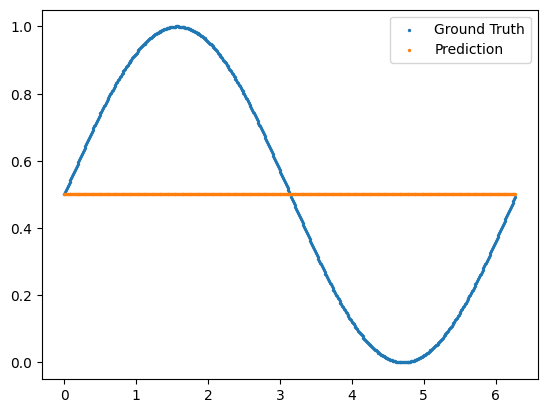

In [17]:
np_model = NumpyModel()
y_pred = np_model(x)
plt.scatter(x.flatten(), y_true.flatten(), s=2, label="Ground Truth")
plt.scatter(x.flatten(), y_pred.flatten(), s=2, label="Prediction")
plt.legend()

I can converge pretty fast using just 30 epochs to overfit the model to the training data, compared to that 60 epochs from TensorFlow implementation.

In [18]:
from optimizers.adam import Adam

N = x.shape[0]
batch_size = 16
epochs = 30
history = []

np.random.seed(1337)
optim = Adam(learning_rate=1e-2)
np_model = NumpyModel()
loss_fn = MeanSquaredError()

for epoch in tqdm(range(epochs), desc="Training progress"):
    for i in range(N // batch_size):
        start = i * batch_size
        end = start + batch_size
        batch_x = x[start:end]
        batch_y = y_true[start:end]
        batch_y_pred = np_model(batch_x)
        
        loss = loss_fn(batch_y, batch_y_pred)
        grad_affine_3_act = loss_fn.gradients()
        grad_affine_3 = np_model.act_3.gradients(grad_affine_3_act)
        grad_affine_2_act, grad_dense_3_kernel, grad_dense_3_bias = np_model.dense_3.gradients(grad_affine_3)
        grad_affine_2 = np_model.act_2.gradients(grad_affine_2_act)
        grad_affine_1_act, grad_dense_2_kernel, grad_dense_2_bias = np_model.dense_2.gradients(grad_affine_2)
        grad_affine_1 = np_model.act_1.gradients(grad_affine_1_act)
        _, grad_dense_1_kernel, grad_dense_1_bias = np_model.dense_1.gradients(grad_affine_1)
        
        grads = {
            "dense_1/kernel": grad_dense_1_kernel,
            "dense_1/bias": grad_dense_1_bias,
            "dense_2/kernel": grad_dense_2_kernel,
            "dense_2/bias": grad_dense_2_bias,
            "dense_3/kernel": grad_dense_3_kernel,
            "dense_3/bias": grad_dense_3_bias,
        }
        for key in grads:
            optim.update(i+1, key, np_model.params, grads)
            
    # Compute epoch loss
    y_pred = np_model(x)
    loss = mse(y_true, y_pred)
    history.append((epoch, loss))

Training progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.95it/s]


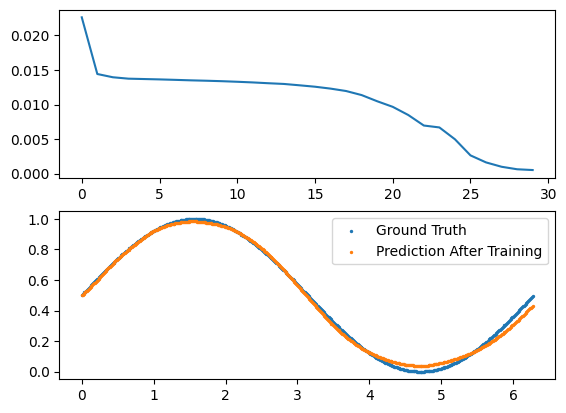

In [19]:
fig, axs = plt.subplots(2)
axs[0].plot([dp[0] for dp in history], [dp[1] for dp in history])

y_pred = np_model(x)
axs[1].scatter(x.flatten(), y_true.flatten(), s=2, label="Ground Truth")
axs[1].scatter(x.flatten(), y_pred.flatten(), s=2, label="Prediction After Training")
axs[1].legend()